<a href="https://colab.research.google.com/github/dsw2xxx/nlp-mimic-III/blob/minor-update/NLP_Similarity_MIMIC-III_1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

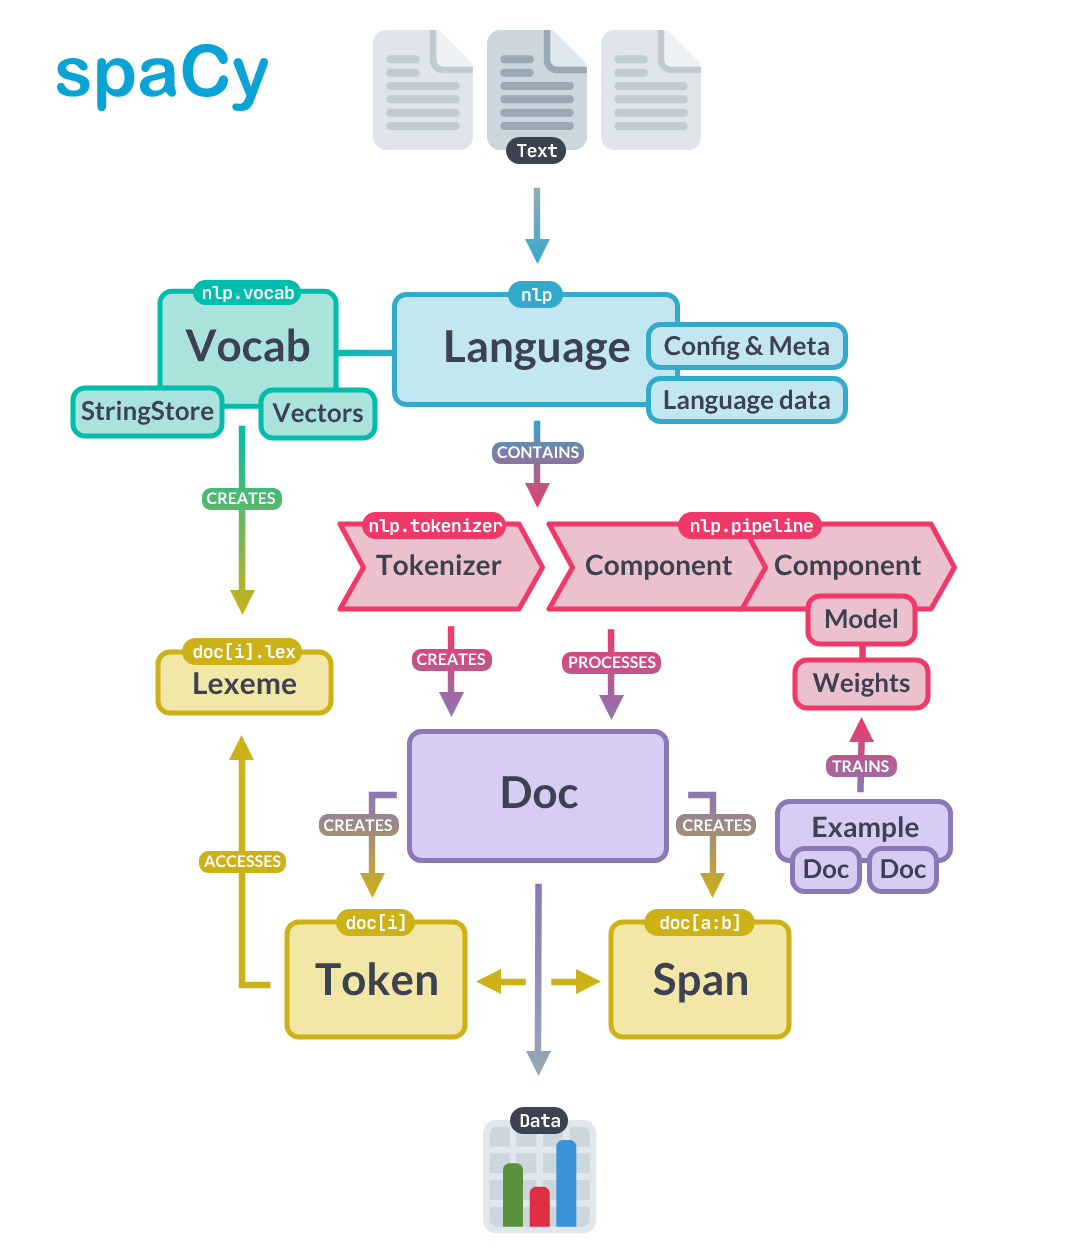

In [1]:
! pip install -U pip setuptools wheel &> /dev/null
! pip install -U spacy &> /dev/null
! python -m spacy download en_core_web_lg &> /dev/null

! pip install scispacy &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_scibert-0.4.0.tar.gz &> /dev/null
#! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_craft_md-0.4.0.tar.gz &> /dev/null
#! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_jnlpba_md-0.4.0.tar.gz &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz &> /dev/null
#! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz &> /dev/null

# Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## MIMIC-III: ADMISSIONS.csv

In [4]:
dt_admissions = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/ADMISSIONS.csv')
print(dt_admissions.shape)
dt_admissions.head()

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


## MIMIC-III: NOTEEVENTS.csv

In [5]:
dt_noteevents = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/NOTEEVENTS.csv')
print(dt_noteevents.shape)
dt_noteevents.head()

(2083180, 11)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


## Merge ADMISSIONS.csv and NOTEEVENTS.csv

In [6]:
col_merged = ['SUBJECT_ID', 'HADM_ID', 'DIAGNOSIS', 'ETHNICITY', 'TEXT']

dt = pd.merge(dt_admissions, dt_noteevents, how='left', on=['SUBJECT_ID', 'HADM_ID'])[col_merged].drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID'], keep='first', ignore_index=True)
print(dt.shape)
dt.head()

(58976, 5)


,SUBJECT_ID,HADM_ID,DIAGNOSIS,ETHNICITY,TEXT
0,22,165315,BENZODIAZEPINE OVERDOSE,WHITE,Admission Date: [**2196-4-9**] Discharg...
1,23,152223,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,Admission Date: [**2153-9-3**] D...
2,23,124321,BRAIN MASS,WHITE,Admission Date: [**2157-10-18**] ...
3,24,161859,INTERIOR MYOCARDIAL INFARCTION,WHITE,Admission Date: [**2139-6-6**] D...
4,25,129635,ACUTE CORONARY SYNDROME,WHITE,Admission Date: [**2160-11-2**] ...


# Preprocess Dataset

## Column: ETHNICITY

In [7]:
dt['ETHNICITY'].replace('^WHITE\D*', 'WHITE', regex=True, inplace=True)
dt['ETHNICITY'].replace('^BLACK\D*', 'BLACK', regex=True, inplace=True)
dt['ETHNICITY'].replace('^HISPANIC\D*', 'HISPANIC/LATINO', regex=True, inplace=True)
dt['ETHNICITY'].replace('^ASIAN\D*', 'ASIAN', regex=True, inplace=True)
dt.loc[~dt['ETHNICITY'].isin(['WHITE', 'BLACK', 'HISPANIC/LATINO', 'ASIAN']), 'ETHNICITY'] = 'UNKNOWN/NOT SPECIFIED'

To examine similarity between documents, we need to compare word vectors or “word embeddings” which is multi-dimensional meaning representations of a word.

Word vectors can be generated using an algorithm like word2vec and usually look like this:

In [8]:
import scispacy
import spacy

#nlp = spacy.load('en_core_web_lg') # spacy
nlp = spacy.load('en_core_sci_lg') # scispacy
#nlp = spacy.load('en_core_sci_scibert') # scispacy
#nlp = spacy.load('en_ner_bc5cdr_md')

# Extract sub-dataframe: Pneumonia

In [9]:
dt_pneumonia = dt.loc[dt['DIAGNOSIS'] == 'PNEUMONIA'].reset_index(drop=True)
dt_pneumonia

,SUBJECT_ID,HADM_ID,DIAGNOSIS,ETHNICITY,TEXT
0,357,101651,PNEUMONIA,WHITE,Admission Date: [**2199-10-20**] ...
1,368,105889,PNEUMONIA,WHITE,Admission Date: [**2137-7-11**] Discharge...
2,368,138061,PNEUMONIA,WHITE,Admission Date: [**2139-12-16**] ...
3,370,123421,PNEUMONIA,WHITE,Admission Date: [**2153-3-4**] Discharg...
4,68,170467,PNEUMONIA,BLACK,Admission Date: [**2173-12-15**] ...
...,...,...,...,...,...
1561,96244,186668,PNEUMONIA,WHITE,Admission Date: [**2184-2-1**] D...
1562,96260,146313,PNEUMONIA,BLACK,Admission Date: [**2194-12-12**] ...
1563,90688,107472,PNEUMONIA,WHITE,Admission Date: [**2153-10-9**] ...
1564,98649,110990,PNEUMONIA,ASIAN,Admission Date: [**2122-6-20**] ...


## Number of Patients per race


In [10]:
# ['UNKNOWN/NOT SPECIFIED', 'WHITE', 'HISPANIC/LATINO', 'BLACK', 'ASIAN']
print('WHITE: {} | BLACK: {} | HISPANIC/LATINO: {} | ASIAN: {} | UNKNOWN/NOT SPECIFIED: {}'.\
      format(len(dt_pneumonia.loc[dt_pneumonia['ETHNICITY'] == 'WHITE']),
             len(dt_pneumonia.loc[dt_pneumonia['ETHNICITY'] == 'BLACK']),
             len(dt_pneumonia.loc[dt_pneumonia['ETHNICITY'] == 'HISPANIC/LATINO']),
             len(dt_pneumonia.loc[dt_pneumonia['ETHNICITY'] == 'ASIAN']),
             len(dt_pneumonia.loc[dt_pneumonia['ETHNICITY'] == 'UNKNOWN/NOT SPECIFIED'])))

WHITE: 1178 | BLACK: 183 | HISPANIC/LATINO: 58 | ASIAN: 54 | UNKNOWN/NOT SPECIFIED: 93


# Compare Similarity Score

In [11]:
dt_pneumonia['TEXT'].isnull().sum()

12

In [12]:
dt_pneumonia.loc[(dt_pneumonia['TEXT'].isnull() == True, 'TEXT')] = 'No Medical Note'

In [13]:
dt_pneumonia['TEXT'].isnull().sum()

0

In [14]:
patients = []

for i in range(len(dt_pneumonia)):

  doc = nlp(dt_pneumonia.loc[i, 'TEXT'])

  patients.append({'SUBJECT_ID': dt_pneumonia.loc[i, 'SUBJECT_ID'],
                    #'HADM_ID': dt_pneumonia.loc[i, 'HADM_ID'],
                    #'DIAGNOSIS': dt_pneumonia.loc[i, 'DIAGNOSIS'],
                    'ETHNICITY': dt_pneumonia.loc[i, 'ETHNICITY'],
                    'TEXT': doc})

In [55]:
similar_white_white = []

for i in range(len(patients)):
  if patients[i]['ETHNICITY'] == 'WHITE':
    for j in range(i+1, len(patients)):
      if patients[j]['ETHNICITY'] == 'WHITE':
        similar_white_white.append((patients[i]['TEXT'].similarity(patients[j]['TEXT'])))

In [56]:
from statistics import mean

print('The average similarity score among white patients is {}.'.format(mean(similar_white_white)))

The average similarity score among white patients is 0.9439962610933423.


In [19]:
similar_white_black = []

for i in range(len(patients)):
  if patients[i]['ETHNICITY'] == 'WHITE':
    for j in range(i+1, len(patients)):
      if patients[j]['ETHNICITY'] == 'BLACK':
        similar_white_black.append((patients[i]['TEXT'].similarity(patients[j]['TEXT'])))
  elif patients[i]['ETHNICITY'] == 'BLACK':
    for j in range(i+1, len(patients)):
      if patients[j]['ETHNICITY'] == 'WHITE':
        similar_white_black.append((patients[i]['TEXT'].similarity(patients[j]['TEXT'])))

In [53]:
print('The average similarity score among white patients is {}.'.format(mean(similar_white_black)))

The average similarity score among white patients is 0.9463530538031277.


In [25]:
similar_white_hispanic = []

for i in range(len(patients)):
  if patients[i]['ETHNICITY'] == 'WHITE':
    for j in range(i+1, len(patients)):
      if patients[j]['ETHNICITY'] == 'HISPANIC/LATINO':
        similar_white_hispanic.append((patients[i]['TEXT'].similarity(patients[j]['TEXT'])))
  elif patients[i]['ETHNICITY'] == 'HISPANIC/LATINO':
    for j in range(i+1, len(patients)):
      if patients[j]['ETHNICITY'] == 'WHITE':
        similar_white_hispanic.append((patients[i]['TEXT'].similarity(patients[j]['TEXT'])))

In [52]:
print('The average similarity score among white patients is {}.'.format(mean(similar_white_hispanic)))

The average similarity score among white patients is 0.9305221148611401.


In [30]:
similar_white_asian = []

for i in range(len(patients)):
  if patients[i]['ETHNICITY'] == 'WHITE':
    for j in range(i+1, len(patients)):
      if patients[j]['ETHNICITY'] == 'ASIAN':
        similar_white_asian.append((patients[i]['TEXT'].similarity(patients[j]['TEXT'])))
  elif patients[i]['ETHNICITY'] == 'ASIAN':
    for j in range(i+1, len(patients)):
      if patients[j]['ETHNICITY'] == 'WHITE':
        similar_white_asian.append((patients[i]['TEXT'].similarity(patients[j]['TEXT'])))

In [51]:
print('The average similarity score among white patients is {}.'.format(mean(similar_white_asian)))

The average similarity score among white patients is 0.947145465023792.


In [33]:
similar_white_unknown = []

for i in range(len(patients)):
  if patients[i]['ETHNICITY'] == 'WHITE':
    for j in range(i+1, len(patients)):
      if patients[j]['ETHNICITY'] == 'UNKNOWN/NOT SPECIFIED':
        similar_white_unknown.append((patients[i]['TEXT'].similarity(patients[j]['TEXT'])))
  elif patients[i]['ETHNICITY'] == 'UNKNOWN/NOT SPECIFIED':
    for j in range(i+1, len(patients)):
      if patients[j]['ETHNICITY'] == 'WHITE':
        similar_white_unknown.append((patients[i]['TEXT'].similarity(patients[j]['TEXT'])))

In [50]:
print('The average similarity score among white patients is {}.'.format(mean(similar_white_unknown)))

The average similarity score among white patients is 0.9276539023293386.


In [46]:
similar_white_others = []

for i in range(len(patients)):
  if patients[i]['ETHNICITY'] == 'WHITE':
    for j in range(i+1, len(patients)):
      if (patients[j]['ETHNICITY'] == 'BLACK') or (patients[j]['ETHNICITY'] == 'HISPANIC/LATINO') or (patients[j]['ETHNICITY'] == 'ASIAN') or (patients[j]['ETHNICITY'] == 'UNKNOWN/NOT SPECIFIED'):
        similar_white_others.append((patients[i]['TEXT'].similarity(patients[j]['TEXT'])))
  elif (patients[i]['ETHNICITY'] == 'BLACK') or (patients[i]['ETHNICITY'] == 'HISPANIC/LATINO') or (patients[i]['ETHNICITY'] == 'ASIAN') or (patients[i]['ETHNICITY'] == 'UNKNOWN/NOT SPECIFIED'):
    for j in range(i+1, len(patients)):
      if patients[j]['ETHNICITY'] == 'WHITE':
        similar_white_others.append((patients[i]['TEXT'].similarity(patients[j]['TEXT'])))

In [49]:
print('The average similarity score among white patients is {}.'.format(mean(similar_white_others)))

The average similarity score among white patients is 0.9396148441645149.


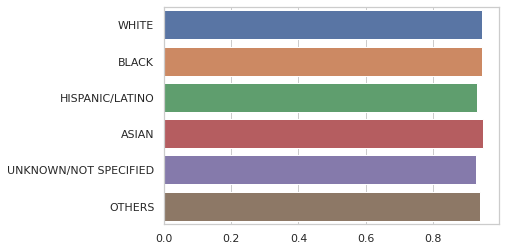

In [70]:
import seaborn as sns

data = {
    'Ethnicity': ['WHITE', 'BLACK', 'HISPANIC/LATINO', 'ASIAN', 'UNKNOWN/NOT SPECIFIED', 'OTHERS'],
    'Mean_Similarity': [mean(similar_white_white), mean(similar_white_black), mean(similar_white_hispanic), mean(similar_white_asian), mean(similar_white_unknown), mean(similar_white_others)]
}

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Mean_Similarity", y="Ethnicity", data=data)